In [ ]:
# !pip install git+https://github.com/mementum/backtrader.git@0fa63ef4a35dc53cc7320813f8b15480c8f85517#egg=backtrader
!pip install backtrader
!pip install yfinance
!pip install mplfinance
!pip install matplotlib==3.2.2

In [1]:
import math
import backtrader as bt
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [ ]:
bt.__file__

In [2]:
def get_yf_data(ticker="BTC-USD", interval="1d", period="max"): 
    ticker_yf = yf.Ticker(ticker)
    hist = ticker_yf.history(period=period, interval=interval)
    return bt.feeds.PandasData(dataname = hist)

In [3]:
class ComissionInfo(bt.CommissionInfo):
    params = (
        ("commission", 0.00075),
        ("mult", 1.0),
        ("margin", None),
        ("commtype", None),
        ("stocklike", False),
        ("percabs", False),
        ("interest", 0.0),
        ("interest_long", False),
        ("leverage", 1.0),
        ("automargin", False),
    )

    def getsize(self, price, cash):
        """Returns fractional size for cash operation @price"""
        return self.p.leverage * (cash / price)

In [21]:
class BuyAndHold(bt.Strategy):
    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def start(self):
        self.cash_start = self.broker.get_cash()

    def nextstart(self):
        size = math.floor( (self.broker.get_cash() - 10) / self.data[0] )
        self.buy(size=size)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY and HOLD')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('#Times:         {:.0f}'.format(self.times))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [57]:
class BuyAndHold_More_Fund(bt.Strategy):
    params = dict(
        monthly_cash=1000
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0
        self.buys = 0
        self.sells = 0
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=1000.0)

        self.cash_start = self.broker.get_cash()
        self.order_target_value(target=self.cash_start)
        print(f"Starting with {self.broker.get_value()}")

        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[0],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
        self.broker.add_cash(self.p.monthly_cash)

        target_value = self.broker.get_value()
        self.order_target_value(target=target_value)
#         print(f"Cash in Account : {self.broker.get_cash()}, Total Assets: {self.broker.get_value()}")
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buys += 1

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1
            elif order.issell():
                self.sells += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
#             self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])
        
        else:
            print(f"Unknown Order : {order.status} ")

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY & BUY MORE')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('Buy Orders:         {:.0f}'.format(self.buys))
        print('Sell Orders:        {:.0f}'.format(self.sells))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
        print(f'Final Brokerage Value:     {self.broker.get_value():,.2f}')
        print(f'Final Brokerage Cash:     {self.broker.get_cash():,.2f}')
        print(f'Final Fund Value:     {self.broker.get_fundvalue():,.2f}')
        print(f'Final Fund Shares:     {self.broker.get_fundshares():,.2f}')
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [18]:
def test_strategy(data, strategy=None, initial_cash=1000):
    # BUY and HOLD
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(strategy)

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    ankwargs = dict(timeframe=bt.TimeFrame.Years)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, **ankwargs)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=True, **ankwargs)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, fund=False, **ankwargs)
    comminfo = ComissionInfo()
    cerebro.broker.addcommissioninfo(comminfo)

    cerebro.broker.set_cash(initial_cash)
    cerebro.run()
    cerebro.plot(iplot=True, style='candlestick')



In [22]:

strategy = BuyAndHold
test_strategy(data, strategy=strategy)


2014-09-18, BUY EXECUTED, Price 457.33, Cost 914.67, Comm 0.01, Size 2
--------------------------------------------------
BUY and HOLD
#Times:         1
Value:         $69,182.75
Cost:          $914.67
Gross Return:  $68,268.08
Gross %:        7463.64%
ROI:            6818.28%
Fund Value:     5918.28%
--------------------------------------------------


Starting with 1000
7 [5, 7, 8]
--------------------------------------------------
BUY & BUY MORE
Buy Orders:         93
Sell Orders:        0
Value:         $3,137,117.76
Cost:          $93,000.01
Gross Return:  $3,044,117.75
Gross %:        3273.24%
ROI:            313611.78%
Fund Value:     7721.99%
Final Brokerage Value:     3,137,117.76
Final Brokerage Cash:     999.99
Final Fund Value:     8,721.99
Final Fund Shares:     359.68
--------------------------------------------------


<IPython.core.display.Javascript object>


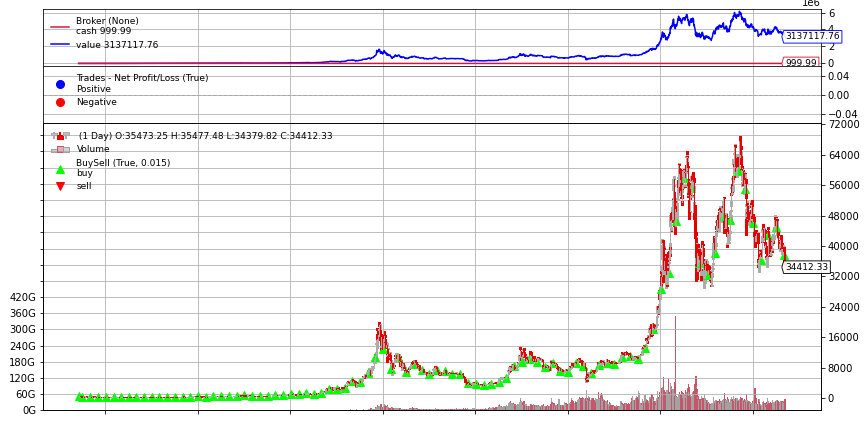

In [58]:
data = get_yf_data()
strategy = BuyAndHold_More_Fund
test_strategy(data, strategy=strategy)

In [55]:
class ValueInvesting(bt.Strategy):
    params = dict(
        monthly_increase = 1000
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.buys = 0
        self.sells = 0
        self.asset_amount_increase = 1000
        self.months_passed_since_start = 1

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=1000.0)
        self.cash_start = self.broker.get_cash()
        self.order_target_value(target=self.cash_start)
        print(f"Starting with {self.broker.get_value()}")

        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[0],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
        investment_period_value = self.params.monthly_increase * self.months_passed_since_start
        actual_value = self.broker.get_value()
        print(f"Equity Currently = {actual_value}, should have {investment_period_value}")
        difference_in_cost = actual_value - investment_period_value
        if difference_in_cost < 0:
            # Equity has decreased therefore need to add funds and buy
            print("Buying...")
            current_cash = self.broker.get_cash()
            topup_amount = abs(difference_in_cost - current_cash)
            print(f"Current Cash {current_cash}, Need to TopUp By {topup_amount}")
            self.broker.add_cash(topup_amount)
            self.order_target_value(target=difference_in_cost)
            
        elif difference_in_cost > 0:
            # Equity has increased and need to sell
            print("Selling...")
            self.order_target_value(target=difference_in_cost)
            
        
        else:
            pass
            
        self.months_passed_since_start += 1
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.buys += 1
            elif order.issell():
                self.sells += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(order.status, [order.Canceled, order.Margin, order.Rejected])
        
        else:
            print(f"Unknown Order : {order.status} ")

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY & BUY MORE')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('Buy Orders:         {:.0f}'.format(self.buys))
        print('Sell Orders:        {:.0f}'.format(self.sells))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
        print(f'Final Brokerage Value:     {self.broker.get_value():,.2f}')
        print(f'Final Brokerage Cash:     {self.broker.get_cash():,.2f}')
        print(f'Final Fund Value:     {self.broker.get_fundvalue():,.2f}')
        print(f'Final Fund Shares:     {self.broker.get_fundshares():,.2f}')
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [56]:
data = get_yf_data()
strategy = ValueInvesting
test_strategy(data, strategy=strategy)

Starting with 1000
Equity Currently = 1000.0, should have 1000
7 [5, 7, 8]
Equity Currently = 1000.0, should have 2000
Buying...
Current Cash 1000.0, Need to TopUp By 2000.0
Equity Currently = 3150.836441940587, should have 3000
Selling...
Equity Currently = 3175.5999982544545, should have 4000
Buying...
Current Cash 2999.9925000562507, Need to TopUp By 3824.3925018017962
Equity Currently = 7141.272835079597, should have 5000
Selling...
Equity Currently = 6546.551723104008, should have 6000
Selling...
Equity Currently = 6626.562513367996, should have 7000
Buying...
Current Cash 5999.992499841128, Need to TopUp By 6373.429986473132
Equity Currently = 13018.54190574268, should have 8000
Selling...
Equity Currently = 12710.149877156085, should have 9000
Selling...
Equity Currently = 12563.817193874005, should have 10000
Selling...
Equity Currently = 12974.329218763272, should have 11000
Selling...
Equity Currently = 13149.752587632362, should have 12000
Selling...
Equity Currently = 12931

TODO
Same Plot Available - https://www.backtrader.com/docu/plotting/sameaxis/plot-sameaxis/

Refer to this around the final results and amount held https://community.backtrader.com/topic/304/how-is-getvalue-calculated/2

Playing around with analysers here :https://community.backtrader.com/topic/2549/beginner-optimizer-and-analyzer-help/10